In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler

In [15]:
# Hyperparameters
window = 10

In [16]:
dataset = pd.read_csv("df_final.csv")
dataset.columns = [x.lower() for x in dataset.columns]
dataset["date"] = pd.to_datetime(dataset["date"])
dataset = dataset.set_index("date")
dataset = dataset.filter(["date", "count_negatives", "count_positives", "count_neutrals", "sent_negatives", "sent_positives", "close"])
dataset = dataset.dropna()

In [17]:
X = dataset.drop("close", axis=1).values
y = dataset["close"].values
y_max, y_min = np.max(y), np.min(y)
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(X)
X_normalized = scaler.transform(X)
y = y.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(y)
y_normalized = scaler.transform(y)

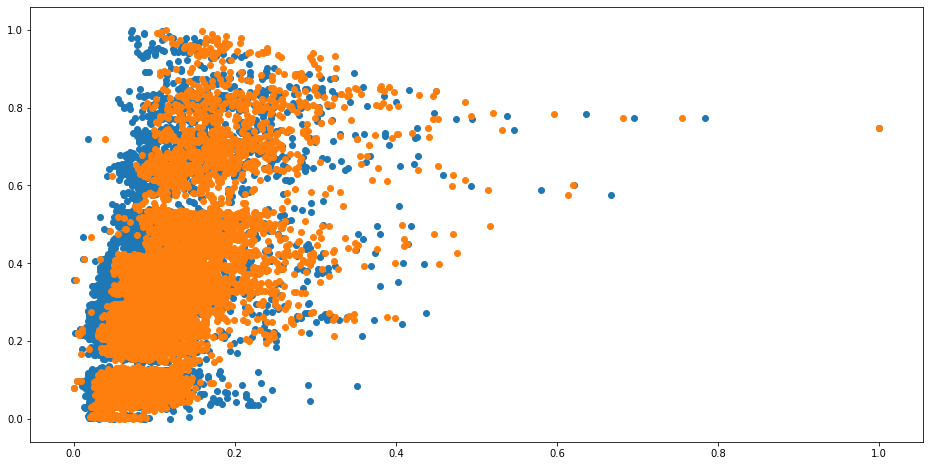

In [18]:
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(X_normalized[:, 0], y_normalized)
ax.scatter(X_normalized[:, 1], y_normalized)
plt.show()

In [19]:
def to_time_series(inputX, inputy):
    tsX, tsy = [], []
    for i in range(len(inputX) - window - 1):
        tsX.append(inputX[i : i + window])
        tsy.append(inputy[i + window - 1])
    return np.array(tsX), np.array(tsy)

tsX, tsy = to_time_series(X, y)
tsX_normalized, tsy_normalized = to_time_series(X_normalized, y_normalized)

In [20]:
def train_test_splitter(inputX, inputy, split=0.8):
    split = int(split * len(inputX))
    inputX_train, inputX_test = inputX[:split], inputX[split:]
    inputy_train, inputy_test = inputy[:split], inputy[split:]
    return inputX_train, inputX_test, inputy_train, inputy_test

tsX_train, tsX_test, tsy_train, tsy_test = train_test_splitter(tsX, tsy)
tsX_norm_train, tsX_norm_test, tsy_norm_train, tsy_norm_test = train_test_splitter(tsX_normalized, tsy_normalized)

In [21]:
tsX_train.shape, tsX_test.shape, tsy_train.shape, tsy_test.shape

((9876, 10, 5), (2470, 10, 5), (9876, 1), (2470, 1))

In [163]:
model = Sequential()
model.add(LSTM(20, activation="relu", input_shape=(window, 5)))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="sgd")
model.fit(tsX_normalized, tsy_normalized, epochs=100, batch_size=10, verbose=2, validation_split=0.2)

Train on 9876 samples, validate on 2470 samples
Epoch 1/100
 - 5s - loss: 0.0282 - val_loss: 0.0334
Epoch 2/100
 - 4s - loss: 0.0217 - val_loss: 0.0317
Epoch 3/100
 - 4s - loss: 0.0179 - val_loss: 0.0238
Epoch 4/100
 - 4s - loss: 0.0161 - val_loss: 0.0284
Epoch 5/100
 - 4s - loss: 0.0155 - val_loss: 0.0232
Epoch 6/100
 - 4s - loss: 0.0151 - val_loss: 0.0207
Epoch 7/100
 - 5s - loss: 0.0149 - val_loss: 0.0251
Epoch 8/100
 - 5s - loss: 0.0147 - val_loss: 0.0189
Epoch 9/100
 - 5s - loss: 0.0145 - val_loss: 0.0195
Epoch 10/100
 - 5s - loss: 0.0144 - val_loss: 0.0263
Epoch 11/100
 - 5s - loss: 0.0143 - val_loss: 0.0204
Epoch 12/100
 - 5s - loss: 0.0142 - val_loss: 0.0301
Epoch 13/100
 - 4s - loss: 0.0140 - val_loss: 0.0205
Epoch 14/100
 - 5s - loss: 0.0140 - val_loss: 0.0189
Epoch 15/100
 - 5s - loss: 0.0139 - val_loss: 0.0213
Epoch 16/100
 - 5s - loss: 0.0138 - val_loss: 0.0188
Epoch 17/100
 - 5s - loss: 0.0137 - val_loss: 0.0270
Epoch 18/100
 - 4s - loss: 0.0137 - val_loss: 0.0237
Epoch 1

In [22]:
model = load_model("bitcoin_tweet_predictor.h5")

In [23]:
tsy_norm_predicted = model.predict(tsX_norm_test)
results = pd.DataFrame([tsy_norm_predicted[:, 0], tsy_norm_test[:, 0]]).T

In [24]:
results

,0,1
0,0.268622,0.227738
1,0.277169,0.228382
2,0.295644,0.228071
3,0.289981,0.228535
4,0.292764,0.229129
...,...,...
2465,0.258939,0.053217
2466,0.263875,0.052951
2467,0.268816,0.053013
2468,0.271317,0.053076
